# Heat transfer simulation using Physics-Informed Neural Network

In [1]:
import sys
sys.path.append('./src')

In [2]:
from heat_solver import HeatForwardSolver
import plotter
from params import u0, options, boundaries
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm
from pinn import PINN
import data_generation as dg
from predict import predict
from pprint import pprint

## Numerical simulation using FDM

Running solver: 100%|██████████| 599/599 [00:09<00:00, 66.12it/s]


Time: 9.06515 seconds


Generating animation: 601it [00:36, 16.59it/s]                         

Plot animated and saved to plots/numerical_prediction.gif


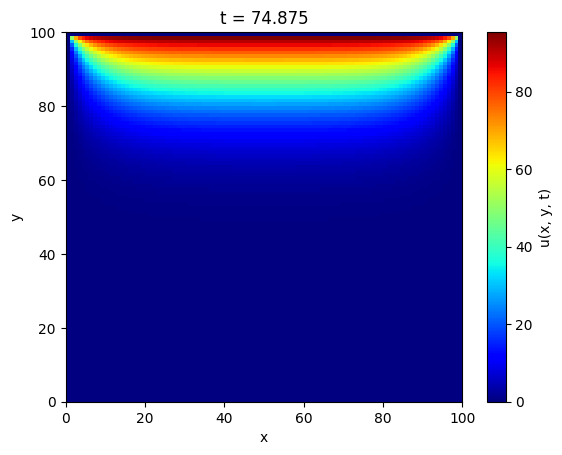

{'alpha': 2.0,
 'delta_t': 0.125,
 'delta_x': 1,
 'domain_length': 100,
 'max_iter': 600,
 't_end': 75.0}


In [3]:
solver = HeatForwardSolver(**options)
solver.set_initial(u0)
solver.set_boundaries(boundaries)

solver.solve()

plotter.animate_plot(solver.u, solver.delta_t, filename='plots/numerical_prediction.gif')
plt = plotter.plot_frame(solver.u, solver.u.shape[2]-1, solver.delta_t)
plt.show()

pprint(options)

## PINN traning and prediciton

In [5]:
device = device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

scaled_alpha = dg.scale_alpha(options['alpha'])

### Traning with COLLOCATION points ONLY

/home/nkusla/Projects/heat-transfer-pinn/venv/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch: 0, Loss: 0.008008666336536407
Epoch: 100, Loss: 3.0120967494440265e-05
Epoch: 200, Loss: 1.4793403352086898e-05
Epoch: 300, Loss: 8.11634527053684e-06
Epoch: 400, Loss: 4.774036369781243e-06
Epoch: 500, Loss: 3.1264669360098196e-06
Epoch: 600, Loss: 2.24051268560288e-06
Epoch: 700, Loss: 1.692893647486926e-06
Epoch: 800, Loss: 1.3135149856680073e-06
Epoch: 900, Loss: 1.034660840559809e-06
Epoch: 1000, Loss: 8.252689553955861e-07
Epoch: 1100, Loss: 6.671992878182209e-07
Epoch: 1200, Loss: 5.477221520777675e-07
Epoch: 1300, Loss: 4.57165015177452e-07
Epoch: 1400, Loss: 3.8806510360700486e-07
Epoch: 1500, Loss: 3.3470476523689285e-07
Epoch: 1600, Loss: 2.9279706836859987e-07
Epoch: 1700, Loss: 2.5916671120285173e-07
Epoch: 1800, Loss: 2.315348837100828e-07
Epoch: 1900, Loss: 2.0829359925755853e-07
Epoch: 2000, Loss: 1.8832783155176003e-07
Epoch: 2100, Loss: 1.708810373202141e-07
Epoch: 2200, Loss: 1.5543828624231537e-07
Epoch: 2300, Loss: 1.4164861283916252e-07
Epoch: 2400, Loss: 1

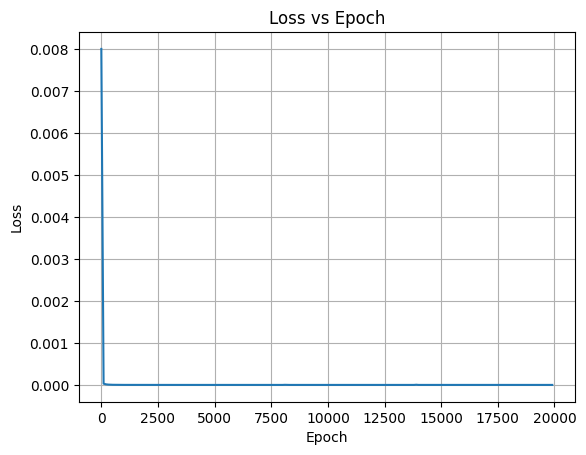

Predicting: 100%|██████████| 600/600 [00:00<00:00, 2286.17it/s]


Time: 0.26411 seconds


Generating animation: 601it [00:38, 15.48it/s]                         

Plot animated and saved to plots/pinn_prediction_colloc.gif


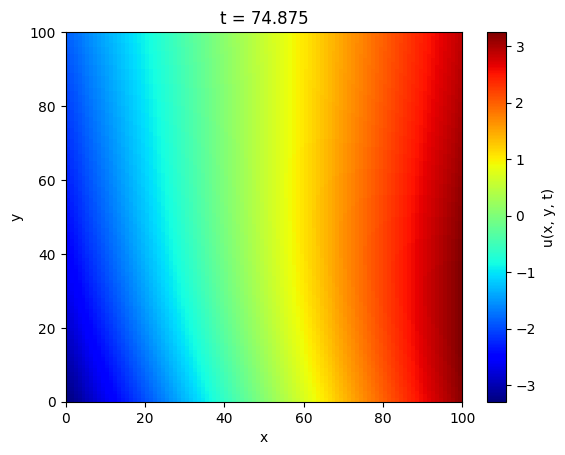

In [5]:
pinn = PINN([3, 40, 40, 40, 40, 40, 1], device, scaled_alpha)

traning_data = dg.generate_traning_data(device, n_colloc=10_000)

pinn.start_train(traning_data, 20_000)
plotter.plot_loss(pinn.loss_history, pinn.epoch_history).show()

u = predict(pinn)

plotter.animate_plot(u, options['delta_t'], filename="plots/pinn_prediction_colloc.gif")
plt = plotter.plot_frame(u, u.shape[2]-1, options['delta_t'])
plt.show()

### Traning with collocation points, BC and IC

Epoch: 0, Loss: 0.3633330762386322
Epoch: 100, Loss: 0.15332448482513428
Epoch: 200, Loss: 0.13947951793670654
Epoch: 300, Loss: 0.11539509892463684
Epoch: 400, Loss: 0.09576381742954254
Epoch: 500, Loss: 0.08103272318840027
Epoch: 600, Loss: 0.06694581359624863
Epoch: 700, Loss: 0.05526570975780487
Epoch: 800, Loss: 0.046198755502700806
Epoch: 900, Loss: 0.040118660777807236
Epoch: 1000, Loss: 0.03629700094461441
Epoch: 1100, Loss: 0.033983923494815826
Epoch: 1200, Loss: 0.03230199217796326
Epoch: 1300, Loss: 0.030870676040649414
Epoch: 1400, Loss: 0.02954176440834999
Epoch: 1500, Loss: 0.028420835733413696
Epoch: 1600, Loss: 0.027509458363056183
Epoch: 1700, Loss: 0.026623323559761047
Epoch: 1800, Loss: 0.025842927396297455
Epoch: 1900, Loss: 0.025108925998210907
Epoch: 2000, Loss: 0.024392154067754745
Epoch: 2100, Loss: 0.0242561474442482
Epoch: 2200, Loss: 0.023160088807344437
Epoch: 2300, Loss: 0.02264666184782982
Epoch: 2400, Loss: 0.022182727232575417
Epoch: 2500, Loss: 0.021775

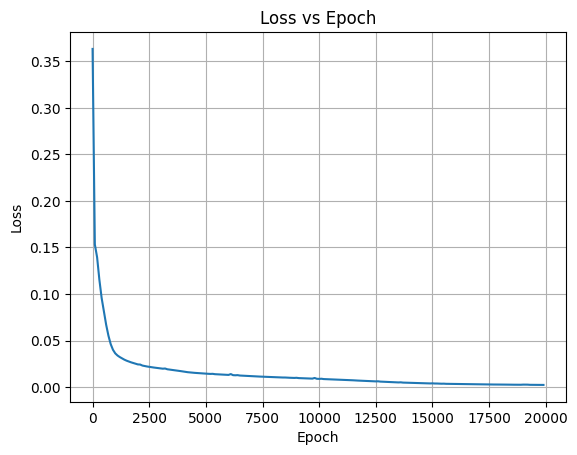

Predicting: 100%|██████████| 600/600 [00:00<00:00, 2064.33it/s]


Time: 0.29221 seconds


Generating animation: 601it [00:38, 15.60it/s]                         

Plot animated and saved to plots/pinn_prediction_pde.gif


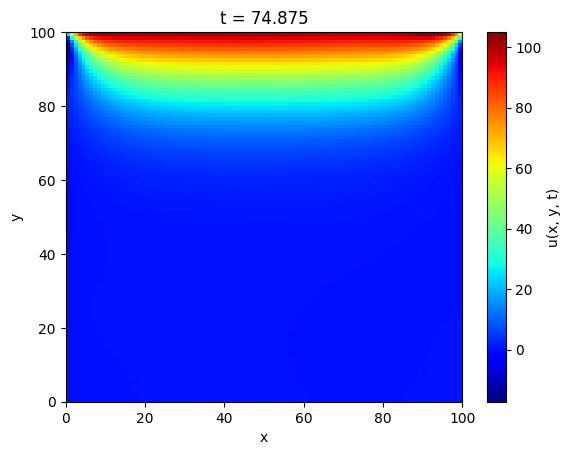

In [6]:
pinn = PINN([3, 40, 40, 40, 40, 40, 1], device, scaled_alpha)

traning_data = dg.generate_traning_data(device, n_colloc=10_000, n_bc=2000, n_ic=800)

pinn.start_train(traning_data, 20_000)
plotter.plot_loss(pinn.loss_history, pinn.epoch_history).show()

u = predict(pinn)

plotter.animate_plot(u, options['delta_t'], filename="plots/pinn_prediction_pde.gif")
plt = plotter.plot_frame(u, u.shape[2]-1, options['delta_t'])
plt.show()

### Training with DATA points ONLY

Generating experimental data: 100%|██████████| 5000/5000 [00:00<00:00, 365663.27it/s]

Epoch: 0, Loss: 0.5788112878799438


Epoch: 100, Loss: 0.03308718279004097
Epoch: 200, Loss: 0.028817329555749893
Epoch: 300, Loss: 0.026998955756425858
Epoch: 400, Loss: 0.026089660823345184
Epoch: 500, Loss: 0.024899013340473175
Epoch: 600, Loss: 0.02273143082857132
Epoch: 700, Loss: 0.01886243000626564
Epoch: 800, Loss: 0.015136904083192348
Epoch: 900, Loss: 0.013705265708267689
Epoch: 1000, Loss: 0.012539319694042206
Epoch: 1100, Loss: 0.01122524868696928
Epoch: 1200, Loss: 0.009733575396239758
Epoch: 1300, Loss: 0.008287765085697174
Epoch: 1400, Loss: 0.007279485929757357
Epoch: 1500, Loss: 0.006746687926352024
Epoch: 1600, Loss: 0.006436581257730722
Epoch: 1700, Loss: 0.0061792791821062565
Epoch: 1800, Loss: 0.005929536186158657
Epoch: 1900, Loss: 0.005690449383109808
Epoch: 2000, Loss: 0.005456961691379547
Epoch: 2100, Loss: 0.005232820753008127
Epoch: 2200, Loss: 0.005015538074076176
Epoch: 2300, Loss: 0.00479934923350811
Epoch: 2400, Loss: 0.004582852590829134
Epoch: 2500, Loss: 0.00436459481716156
Epoch: 2600, L

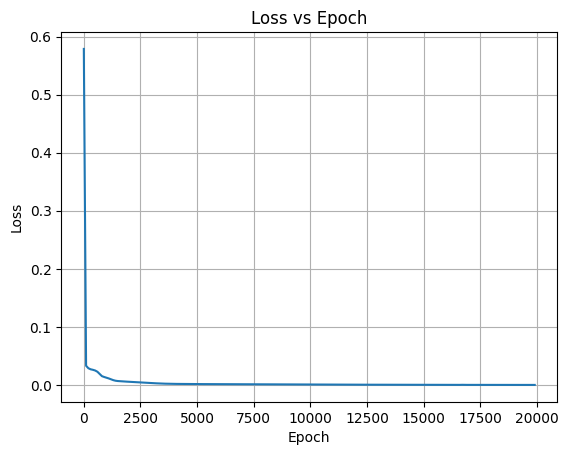

Predicting: 100%|██████████| 600/600 [00:00<00:00, 2078.37it/s]


Time: 0.29023 seconds


Generating animation: 601it [00:39, 15.12it/s]                         

Plot animated and saved to plots/pinn_prediction_data.gif


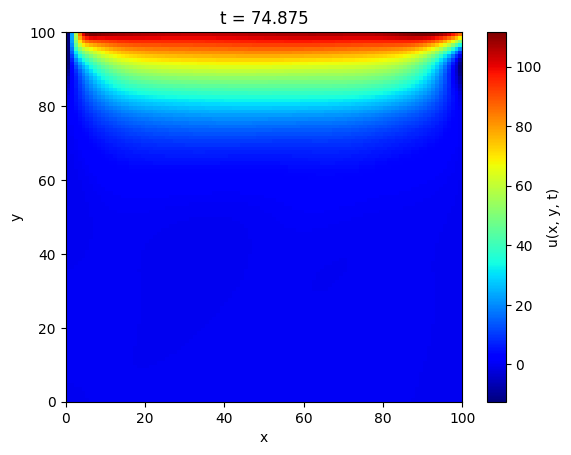

In [7]:
pinn = PINN([3, 40, 40, 40, 40, 40, 1], device, scaled_alpha)

traning_data = dg.generate_traning_data(device, u=solver.u, n_data=5000)

pinn.start_train(traning_data, 20_000)
plotter.plot_loss(pinn.loss_history, pinn.epoch_history).show()

u = predict(pinn)

plotter.animate_plot(u, options['delta_t'], filename="plots/pinn_prediction_data.gif")
plt = plotter.plot_frame(u, u.shape[2]-1, options['delta_t'])
plt.show()

### Training with DATA and PDE (collocation points, BC and IC)

Generating experimental data: 100%|██████████| 5000/5000 [00:00<00:00, 225079.10it/s]


Epoch: 0, Loss: 0.4637924134731293
Epoch: 100, Loss: 0.1828961819410324
Epoch: 200, Loss: 0.16628503799438477
Epoch: 300, Loss: 0.13703133165836334
Epoch: 400, Loss: 0.11283153295516968
Epoch: 500, Loss: 0.09395860135555267
Epoch: 600, Loss: 0.07664000988006592
Epoch: 700, Loss: 0.06287001818418503
Epoch: 800, Loss: 0.05312137305736542
Epoch: 900, Loss: 0.04666479676961899
Epoch: 1000, Loss: 0.041678763926029205
Epoch: 1100, Loss: 0.03882913291454315
Epoch: 1200, Loss: 0.037048742175102234
Epoch: 1300, Loss: 0.035656437277793884
Epoch: 1400, Loss: 0.034361109137535095
Epoch: 1500, Loss: 0.033133283257484436
Epoch: 1600, Loss: 0.032106202095746994
Epoch: 1700, Loss: 0.031274762004613876
Epoch: 1800, Loss: 0.03059612587094307
Epoch: 1900, Loss: 0.0300124641507864
Epoch: 2000, Loss: 0.029446445405483246
Epoch: 2100, Loss: 0.028902385383844376
Epoch: 2200, Loss: 0.028373828157782555
Epoch: 2300, Loss: 0.027963096275925636
Epoch: 2400, Loss: 0.02739023044705391
Epoch: 2500, Loss: 0.02693600

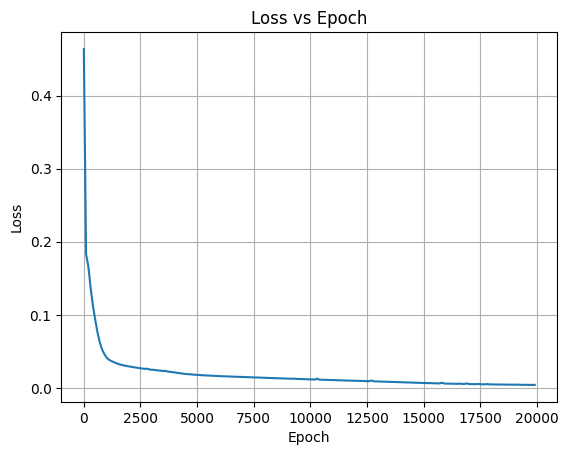

Predicting: 100%|██████████| 600/600 [00:00<00:00, 2271.83it/s]


Time: 0.26562 seconds


Generating animation: 601it [00:37, 15.95it/s]                         

Plot animated and saved to plots/pinn_prediction_all.gif


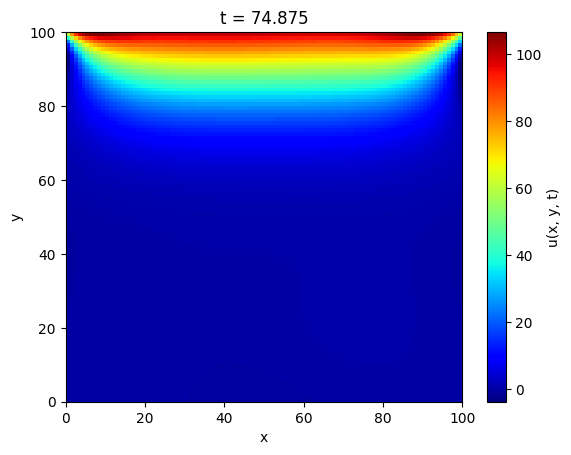

In [7]:
pinn = PINN([3, 40, 40, 40, 40, 40, 1], device, scaled_alpha)

traning_data = dg.generate_traning_data(device, u=solver.u, n_data=5000, n_colloc=10_000, n_bc=2000, n_ic=800)

pinn.start_train(traning_data, 20_000)
plotter.plot_loss(pinn.loss_history, pinn.epoch_history).show()

u_all = predict(pinn)

plotter.animate_plot(u_all, options['delta_t'], filename="plots/pinn_prediction_all.gif")
plt = plotter.plot_frame(u_all, u_all.shape[2]-1, options['delta_t'])
plt.show()

### PDE discovery (learning ALPHA)

Generating experimental data: 100%|██████████| 5000/5000 [00:00<00:00, 134458.68it/s]


Epoch: 0, Loss: 0.2551741600036621, Alpha: 0.9998000264167786
Epoch: 100, Loss: 0.17879658937454224, Alpha: 0.9903516173362732
Epoch: 200, Loss: 0.1631162017583847, Alpha: 0.982356607913971
Epoch: 300, Loss: 0.14817139506340027, Alpha: 0.9599883556365967
Epoch: 400, Loss: 0.133480504155159, Alpha: 0.9304394125938416
Epoch: 500, Loss: 0.1211630329489708, Alpha: 0.9047260880470276
Epoch: 600, Loss: 0.11141583323478699, Alpha: 0.8844408988952637
Epoch: 700, Loss: 0.10458967089653015, Alpha: 0.8688475489616394
Epoch: 800, Loss: 0.10046926885843277, Alpha: 0.8548874855041504
Epoch: 900, Loss: 0.09767239540815353, Alpha: 0.8409028053283691
Epoch: 1000, Loss: 0.09533147513866425, Alpha: 0.8265140652656555
Epoch: 1100, Loss: 0.09319174289703369, Alpha: 0.8118329048156738
Epoch: 1200, Loss: 0.09131442755460739, Alpha: 0.797032356262207
Epoch: 1300, Loss: 0.08964569866657257, Alpha: 0.7822681665420532
Epoch: 1400, Loss: 0.08812646567821503, Alpha: 0.7675467133522034
Epoch: 1500, Loss: 0.08673188

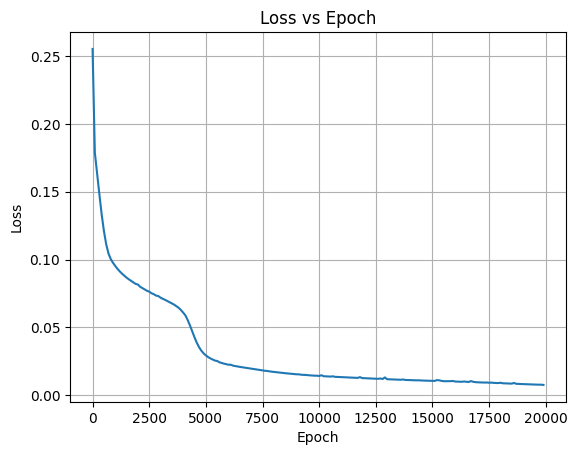

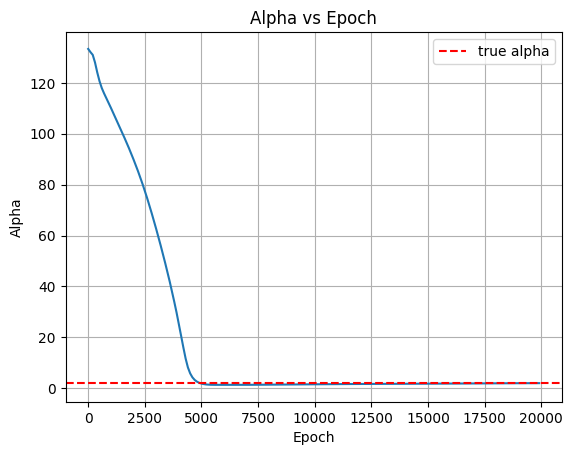

Predicting: 100%|██████████| 600/600 [00:00<00:00, 2210.17it/s]


Time: 0.27304 seconds


Generating animation: 601it [00:39, 15.24it/s]                         

Plot animated and saved to plots/pinn_prediction_alpha.gif


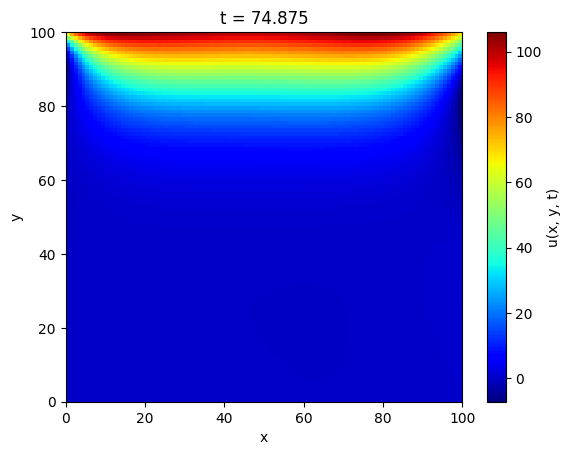

In [12]:
pinn = PINN([3, 40, 40, 40, 40, 40, 1], device)

traning_data = dg.generate_traning_data(device, u=solver.u, n_data=5000, n_colloc=10_000, n_bc=2000, n_ic=800)

pinn.start_train(traning_data, 20_000)
plotter.plot_loss(pinn.loss_history, pinn.epoch_history).show()
plotter.plot_alpha(pinn.alpha_history, pinn.epoch_history, options["alpha"]).show()
u = predict(pinn)

plotter.animate_plot(u, options['delta_t'], filename="plots/pinn_prediction_alpha.gif")
plt = plotter.plot_frame(u, u.shape[2]-1, options['delta_t'])
plt.show()

### Relative errors when comparing PINN and FDM results





















































































































































































































































Generating animation: 601it [00:36, 16.62it/s]                         

Plot animated and saved to plots/pinn_error.gif


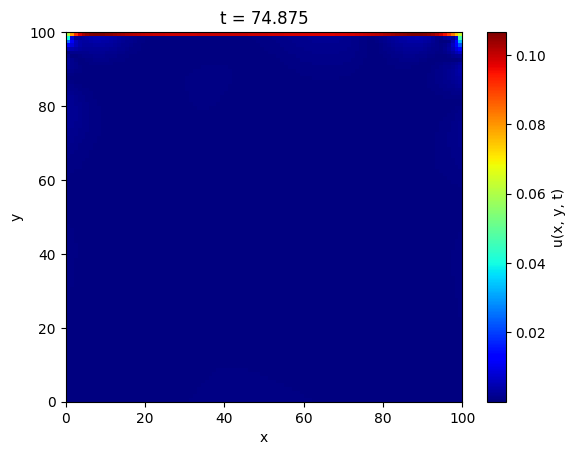

In [12]:
# Relative error calculation

offset = 1000.0
u_true = solver.u + offset
u_pred = u_all + offset
u_error = u_true - u_pred
u_error = np.abs(u_error / u_true)

plotter.animate_plot(u_error, options['delta_t'], filename="plots/pinn_relative_error.gif")
plt = plotter.plot_frame(u_error, u_error.shape[2]-1, options['delta_t'])
plt.show()